In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from tqdm.notebook import tqdm
from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('qick_111_rfbrd_v2.bit')
# Load bitstream with custom overlay
# soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")

soccfg = soc

print(soccfg)

resetting clocks: 204.8

QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v6 - tProc out

### SET UP CONFIGURATION

In [3]:
# Cavity frequencies from CW values, in order of qubits 1-4
brightfreq = [6.1874350, 5.8278950, 6.0745800, 5.9588200] # Power was -20 on VNA, 10 on attenuator
darkfreq = [6.1881200, 5.8286500, 6.0750950, 5.959500] # Power was -60 on VNA, 10 on attenuator
darkfreq800 = [6.18807, 5.8285, 6.075045, 5.95940] # Best for 800 gain

qubitresCW = [4.798, 4.651, 4.491, 4.646] # From coarse CW scans
qubitresPulse = [4.800, 4.6571, 4.4928, 4.6518]

#pipulsegain = 15000 # Good enough for all four qubits
#pipulsegain = [25000, 20000, 25000, 25000] # from single shot
#pipulseshort = [0.16, 0.115, 0.15, 0.125] # Based on 1D, first peak, in us
#pipulselong = [0.48, 0.325, 0.45, 0.375] # Based on 1D, second peak, in us

pipulsegain = [29000, 19500, 28500, 28500] #re-optimized from RabiScans
pipulseshort = [0.06, 0.07, 0.08, 0.06] #re-optimized from RabiScans

#pipulsegain = [0, 0, 0, 0]

hw_cfg={"res_ch":5,
        "qubit_ch":2,
        "ro_ch":1,
        "LB_in":0,
        "LB_out":1
       }

# expt_cfg={"length":200, # [Clock ticks]
#           "reps":1,
#           "gain":3000,
#           "relax_delay":1.0, # --Fixed
#           "reps":1, 
#           "soft_avgs":1,
#           "adc_trig_offset":175
#          }

config={**hw_cfg}

In [4]:
# soc.reset_gens()

In [5]:
# high LO for readout, low LO for qubit
f_lo_ro = 122.88*56
f_lo_qubit = 122.88*28

print("RO sidebands:", 2*f_lo_ro - np.array(darkfreq800)*1e3)


# soc.rfb_set_lo(f_lo, verbose=True)
soc.rfb_set_lo(f_lo_ro, ch=0, verbose=True) # ADCs
soc.rfb_set_lo(f_lo_qubit, ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(f_lo_ro, ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=14.5)
soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=0, att2=16)

soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)

RO sidebands: [7574.49  7934.06  7687.515 7803.16 ]
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   2 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  6881.28 |    0.00 | 2.2400e+02

Choosing solution 0 with minimal metric 224.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   4 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  3440.64 |    0.00 | 4.4800e+02

Choosing solution 0 with minimal metric 448.
lock attempt 1 failed
LO locked on attempt 2 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pf

### SET UP SWEEP

In [6]:
# Can choose a phase from calibration
#phase = 32.757131 # From calibration?
phase = 0

# Set up info for labels and saving
TWPA = "on" # For plot labels
date = "2022-07-26"
shield = "closed"
source = "nosource"

# Choose qubit
qubit = 2

# Set up readout parameters
readout_gain = 800
ro_pulselength = 3.0 # us?

rpos='dark'

if(rpos == 'mid'):
    resf = (brightfreq[qubit-1]+darkfreq[qubit-1])/2
elif(rpos == 'dark'):
    resf = darkfreq800[qubit-1]
elif(rpos == 'bright'):
    resf = brightfreq[qubit-1]

adc_offset = 80 # Check on loopback tests

# Set up qubit parameters
pulsestyle = "const" # "arb" = Gaussian, "const" = square, "flat_top" is Gaussian + square
qu_pulselength = pipulseshort[qubit-1] # Square pulse or flat top length
qsig = qu_pulselength/4 # Sigma for gaussian, where length = 4*sigma
qubit_gain = pipulsegain[qubit-1] # Uses full value for Gaussian and flat top, half for square (see loop backs)

averages = 5000
relax = 10

expt_cfg={"relax_delay":relax,
          "reps":averages,
          "expts":1,
          "start":qubit_gain,
         }

readout_cfg={
    "readout_ch":hw_cfg['ro_ch'],
    "readout_length":soccfg.us2cycles(ro_pulselength, gen_ch=hw_cfg["res_ch"]), # [Clock ticks]
    "f_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - resf*1000), # MHz, start value
    #"f_res": brightfreq[qubit-1]*1000, # MHz, start value
    "res_phase": soccfg.deg2reg(phase, gen_ch=config["res_ch"]),
    "res_gain": readout_gain, # for dark peak
    "adc_trig_offset": adc_offset # [Clock ticks]
    }

qubit_cfg={
    "sigma":soccfg.us2cycles(qsig, gen_ch=config["qubit_ch"]),
    "pulse_length":soccfg.us2cycles(qu_pulselength, gen_ch=config["qubit_ch"]),
    "pulse_style":pulsestyle,
    "qubit_gain":qubit_gain,
    "pi_gain": qubit_gain, # not used in this script
    "pi2_gain":qubit_gain//2,  # not used in this script
    "f_ge": abs(qubitresPulse[qubit-1]*1000 - soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch'])),
    "relax_delay":relax
}


config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

print("qubit IF=%f, readout IF=%f"%(qubit_cfg['f_ge'], readout_cfg['f_res']))

qubit IF=1216.460000, readout IF=1052.780000


In [7]:
#Figure params
rcParams['figure.figsize'] = 16, 8
rcParams.update({'font.size': 22})

#helper functions
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]
    
    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

In [8]:
class NoPulse(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_readout(ch=cfg["readout_ch"], length=cfg["readout_length"],
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])
            
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["readout_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def getAllPulses(self):
        allI = self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        allQ = self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        return allI,allQ

class PiPulse(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=1) #Qubit
        self.declare_readout(ch=cfg["readout_ch"], length=cfg["readout_length"],
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value

        self.f_ge =self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_ge, phase=0, gain=cfg["pi_gain"], 
                                 length=cfg["pulse_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["readout_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def getAllPulses(self):
        allI = self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        allQ = self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        return allI,allQ

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

mean signal is (-645.9821506944444-393.7910887152778j) (magnitude 756.547659)
amplitude noise: 3.391337 ADU, 0.004483 as a fraction of the signal
phase noise: 4.745688 ADU, 0.006273 radians


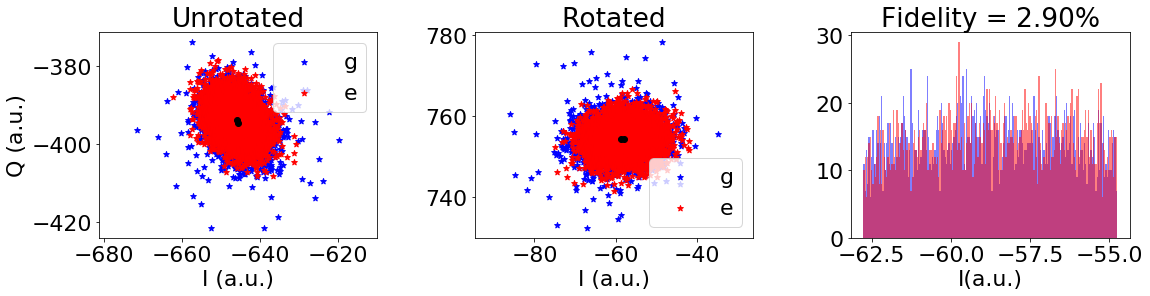

In [11]:
config['reps'] = 5000

config['relax_delay'] = 1

ground=NoPulse(soccfg, config)
avgGi, avgGq = ground.acquire(soc, load_pulses=True,progress=True, debug=False)
gi,gq = ground.getAllPulses()

excited=PiPulse(soccfg, config)
avgEi, avgEq = excited.acquire(soc, load_pulses=True,progress=True, debug=False)
ei,eq = excited.getAllPulses()

fid, threshold, angle = hist(data=[gi[0], gq[0], ei[0], eq[0]],  plot=True, ran=4)

e_complex = ei+1j*eq
e_mean = np.mean(e_complex)
e_mag = np.abs(e_mean)
print("mean signal is %s (magnitude %f)" % (str(e_mean), e_mag))
e_rotated = e_complex*np.exp(-1j*np.angle(e_mean))
e_rmsmag = np.std(np.real(e_rotated)) # noise in the radial direction
e_rmsrot = np.std(np.imag(e_rotated)) # noise in the azimuth direction
print("amplitude noise: %f ADU, %f as a fraction of the signal" % (e_rmsmag, e_rmsmag/e_mag))
print("phase noise: %f ADU, %f radians" % (e_rmsrot, e_rmsrot/e_mag))

# plt.savefig(f"images/Plots_{date}/SS_separated_shield{shield}_{source}_qubit{qubit}_TWPA{TWPA}_shots{averages}_ro{ro_pulselength}_gain{pipulsegain}_L{qu_pulselength}_{pulsestyle}.pdf", dpi=350)

  0%|          | 0/1000 [00:00<?, ?it/s]

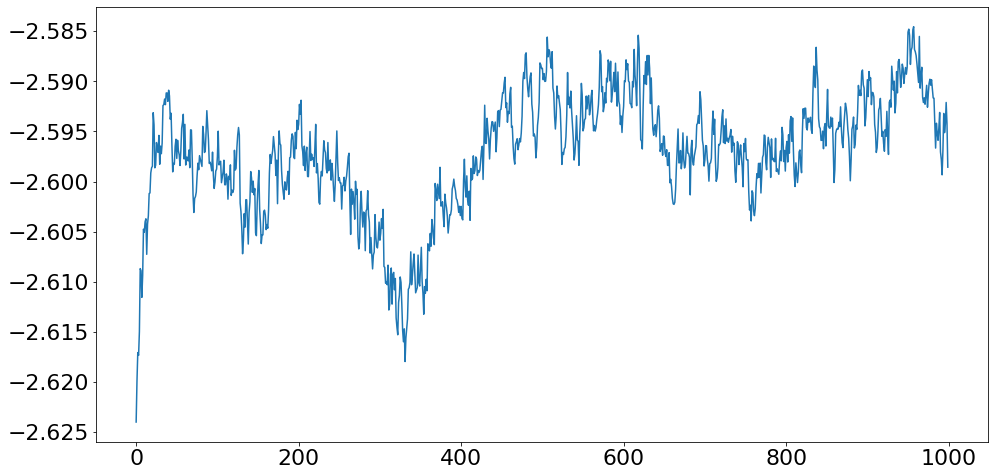

In [10]:
# there is some phase drift, which we have seen before (it's in the RFSoC, not the RF board)
# we suspect some temperature dependence somewhere, probably the ADC
# we don't think tens of milliradians is significant compared to real qubit phase shifts, but we can revisit this

phases = []
for i in tqdm(range(1000)):
    avgEi, avgEq = excited.acquire(soc, load_pulses=True,progress=False, debug=False)
    avgE = avgEi + 1j*avgEq
    phases.append(np.angle(avgE[0]))
#     print(avgE[0], np.angle(avgE[0]))
plt.plot(phases)

In [ ]:
# ground=NoPulse(soccfg, config)
# avgGi, avgGq = ground.acquire(soc, load_pulses=True,progress=True, debug=False)
# gi,gq = ground.getAllPulses()

config['reps'] = 1000000

config['relax_delay'] = 1

excited=PiPulse(soccfg, config)
# ground=NoPulse(soccfg, config)
while True:
    avgEi, avgEq = excited.acquire(soc, load_pulses=True,progress=True, debug=False)
# ei,eq = excited.getAllPulses()

# np.savez(f"data/{date}/SS_separated_shield{shield}_{source}_qubit{qubit}_TWPA{TWPA}_shots{averages}_ro{ro_pulselength}_gain{pipulsegain}_L{qu_pulselength}_{pulsestyle}",Iground=gi,Qground=gq,Iexcited=ei,Qexcited=eq)

In [12]:
class PeriodicPulse(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=1) #Qubit
        self.declare_readout(ch=cfg["readout_ch"], length=cfg["readout_length"],
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value

        self.f_ge =self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_ge, phase=0, gain=cfg["pi_gain"], 
                                 length=cfg["pulse_length"], mode='periodic')
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"], mode='periodic')
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["readout_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def getAllPulses(self):
        allI = self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        allQ = self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        return allI,allQ
    
    
config['reps'] = 100

config['relax_delay'] = 1

excited=PeriodicPulse(soccfg, config)
# ground=NoPulse(soccfg, config)
avgEi, avgEq = excited.acquire(soc, load_pulses=True,progress=True, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# turn off periodic outputs
soc.reset_gens()